# Parametrizing

In [1]:
DATASET_CONFIG_PATH = 'config/dataset/kc1.json'
PROFILE_REPORTING = False

In [2]:
# Parameters
DATASET_CONFIG_PATH = "config/dataset/cm1.json"
PROFILE_REPORTING = False


In [3]:
import json


with open(DATASET_CONFIG_PATH) as f:
    dataset_config = json.load(f)

# Profiling

In [4]:
import pandas as pd
from pandas_profiling import ProfileReport

In [5]:
df = pd.read_csv(dataset_config['dataset_path'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 498 non-null    int64  
 1   loc                498 non-null    float64
 2   v(g)               498 non-null    float64
 3   ev(g)              498 non-null    float64
 4   iv(g)              498 non-null    float64
 5   n                  498 non-null    float64
 6   v                  498 non-null    float64
 7   l                  498 non-null    float64
 8   d                  498 non-null    float64
 9   i                  498 non-null    float64
 10  e                  498 non-null    float64
 11  b                  498 non-null    float64
 12  t                  498 non-null    float64
 13  lOCode             498 non-null    int64  
 14  lOComment          498 non-null    int64  
 15  lOBlank            498 non-null    int64  
 16  locCodeAndComment  498 non

In [7]:
df.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,2,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,3,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,...,1,0,6,0,15.0,15.0,44.0,19.0,9.0,False
3,4,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,...,0,0,3,0,16.0,8.0,31.0,16.0,7.0,False
4,5,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False


In [8]:
del df['id']

In [9]:
if PROFILE_REPORTING:
    ProfileReport(df).to_widgets()

# Preprocess

In [10]:
working_df = df.copy()

In [11]:
working_df['defects'] = working_df['defects'].replace([False, True], [0, 1])

In [12]:
working_df = working_df.drop_duplicates()
working_df = working_df.reset_index(drop=True)

In [13]:
working_df['defects'].value_counts()

0    394
1     48
Name: defects, dtype: int64

# Split

In [14]:
random_state = dataset_config['random_state']

In [15]:
inlier, outlier = working_df[working_df['defects'] == 0], working_df[working_df['defects'] == 1]

In [16]:
X_inlier = inlier.copy().reset_index(drop=True)
y_inlier = X_inlier.pop('defects').reset_index(drop=True)
X_outlier = outlier.copy().reset_index(drop=True)
y_outlier = X_outlier.pop('defects').reset_index(drop=True)

# Naive Bayes

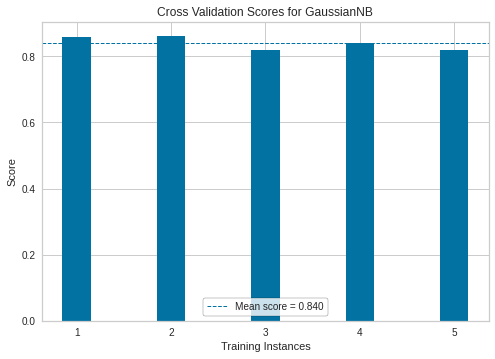

<AxesSubplot:title={'center':'Cross Validation Scores for GaussianNB'}, xlabel='Training Instances', ylabel='Score'>

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

from yellowbrick.model_selection import CVScores


cv = StratifiedKFold(5)
visualizer = CVScores(GaussianNB(), cv=cv, scoring='f1_weighted', random_state=random_state)

X = pd.concat([X_inlier, X_outlier], ignore_index=True)
y = pd.concat([y_inlier, y_outlier], ignore_index=True)

visualizer.fit(X, y)
visualizer.show()

# 1-NN

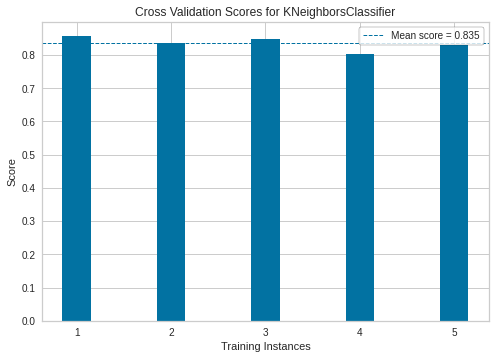

<AxesSubplot:title={'center':'Cross Validation Scores for KNeighborsClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [18]:
from sklearn.neighbors import KNeighborsClassifier


cv = StratifiedKFold(5)
visualizer = CVScores(KNeighborsClassifier(n_neighbors=1), cv=cv, scoring='f1_weighted', random_state=random_state)

X = pd.concat([X_inlier, X_outlier], ignore_index=True)
y = pd.concat([y_inlier, y_outlier], ignore_index=True)

visualizer.fit(X, y)
visualizer.show()

# Kmeans metaclasses + Naive Bayes

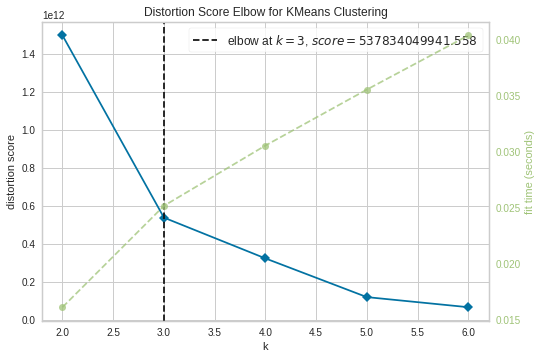

In [19]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7), random_state=random_state)

visualizer.fit(X_inlier)
visualizer.show()
inlier_best_k = visualizer.elbow_value_

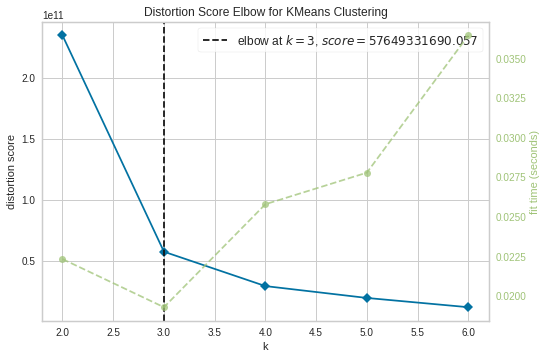

In [20]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7), random_state=random_state)

visualizer.fit(X_outlier)
visualizer.show()
outlier_best_k = visualizer.elbow_value_

## Encoding metaclasses

In [21]:
y_inlier_clustered = pd.Series(KMeans(inlier_best_k, random_state=random_state).fit_predict(X_inlier))
y_outlier_clustered = pd.Series(KMeans(outlier_best_k, random_state=random_state).fit_predict(X_outlier))
y_outlier_clustered = y_outlier_clustered + inlier_best_k

In [22]:
X = pd.concat([X_inlier, X_outlier], ignore_index=True)
y = pd.concat([y_inlier_clustered, y_outlier_clustered], ignore_index=True)

/home/gcc/work/.virtualenvs/tmp-d8e6ef899cc5740/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


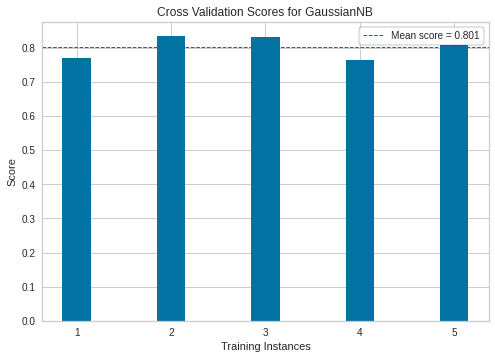

<AxesSubplot:title={'center':'Cross Validation Scores for GaussianNB'}, xlabel='Training Instances', ylabel='Score'>

In [23]:
cv = StratifiedKFold(5)
visualizer = CVScores(GaussianNB(), cv=cv, scoring='f1_weighted', random_state=random_state)

visualizer.fit(X, y)
visualizer.show()